In [38]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from collections import defaultdict as dd
from nltk.probability import FreqDist as fd
import dill as pickle
import numpy as np
from numpy.linalg import norm
from scipy.stats import entropy as H
from itertools import combinations
from collections import defaultdict as dd
from nltk.probability import FreqDist as fd

In [2]:
#adapted from alemol @ https://stackoverflow.com/questions/15880133/jensen-shannon-divergence
#identical dists have divergence of zero
def JSD(prob_distributions, weights, dist_weights, logbase=2):
    # left term: entropy of mixture
    wprobs = weights * prob_distributions
    mixture = wprobs.sum(axis=0)
    entropy_of_mixture = H(mixture, base=logbase)

    # right term: sum of entropies
    entropies = np.array([H(P_i, base=logbase) for P_i in prob_distributions])
    wentropies = dist_weights * entropies
    sum_of_entropies = wentropies.sum()

    divergence = entropy_of_mixture - sum_of_entropies
    return(divergence)

In [14]:
sample_dist1=np.array([0.2,0.4,0.4])
sample_dist2=np.array([1/3,1/3,1/3])
sample_dist3=np.array([0.4,0.3,0.3])
weights=np.array([1/3]*3)
JSD([sample_dist1,sample_dist2,sample_dist3], np.array([1/3,1/3,1/3]),weights)

0.02406037673528827

In [109]:
direc="/home/benjamin/sfi/project_stuff/data/clean/"
months=["Jan", "Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
site_list=["atlantic","breitbart","thehill","motherjones"]
year="2016"
d=[[] for x in range(7)]
for month in months:
    f=open(direc+month+year+"stats.pkl","rb")
    a=pickle.load(f)
    words=set()
    for site in site_list:
        words=words.union(set(a[0][site][year][month].keys()))
    probs=[[a[0][site][year][month].freq(word) for word in words] for site in site_list]
    for a,i in enumerate(combinations(range(4),2)):
        j,k=i
        p_dists=np.array([probs[j],probs[k]])
        n=len(probs[0])
        weights=np.empty(n)
        weights.fill(1/n)
        dist_weights=[1/len(p_dists)]*len(p_dists)
        d[a].append(JSD(p_dists,weights,dist_weights))
    p_dists=np.array(probs)
    n=len(probs[0])
    weights=np.empty(n)
    weights.fill(1/n)
    dist_weights=[1/len(p_dists)]*len(p_dists)
    d[6].append(JSD(p_dists,weights,dist_weights))
    f.close()

In [ ]:
year="2016"
n=["NN","NNP","NNPS","NNS"]
adjs=["JJ","JJR","JJS"]
noun_p=dd(lambda: dd(lambda: [None]*12))
adj_p=dd(lambda: dd(lambda: [None]*12))
other_p=dd(lambda: dd(lambda: [None]*12))
direc="/home/benjamin/sfi/project_stuff/data/cleaner/"
months=["Jan", "Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
site_list=["atlantic","breitbart","thehill","motherjones"]
year="2016"
#site, year, month, word, POS
p_dists=dd(lambda: dd(lambda: dd(lambda: dd(fd))))
for i,month in enumerate(months):
    with open(direc+month+year+"stats.pkl","rb") as f:
        a=pickle.load(f)
        for site in site_list:
            for word in a[1][site][year][month].keys():
                noun_p[site][word][i]=sum([a[1][site][year][month][word].freq(p) for p in n])
                adj_p[site][word][i]=sum([a[1][site][year][month][word].freq(p) for p in adjs])
                other_p[site][word][i]=sum([a[1][site][year][month][month][word].freq(p) for p in p_dists[site]["2016"][month][word].keys() if p not in n and p not in adjs])


In [31]:
noun_p["motherjones"]["black"]

[0.19726678550207963,
 0.22376060741402412,
 0.22356020942408375,
 0.21094369547977795,
 0.20603015075376882,
 0.22210414452709884,
 0.2787630741246021,
 0.37727558066541117,
 0.23221757322175732,
 0.2282051282051282,
 0.28015873015873016,
 0.2872340425531915]

In [29]:
with open("../data/POSstats.pkl", "wb") as f:
    pickle.dump([noun_p, adj_p, other_p], f)

KeyboardInterrupt: 

In [7]:
with open("../data/POSstats.pkl", "rb") as f:
    [noun_p,adj_p,other_p]=pickle.load(f)

from kulkarni
Then we calculate the probability distribution of part of speech tags Q t given the word w
and time snapshot t as follows: Q t = Pr X∼POS Tags (X|w, C t ).
We consider the POS tag distribution at t = 0 to be the
initial distribution Q 0 . To quantify the temporal change
between two time snapshots corpora, for a specific word w,
we calculate the divergence between the POS distributions
in both snapshots.
Specifically, we construct the time series as follows:
T t (w) = JSD(Q 0 , Q t )

In [23]:
at_diverg=dd(lambda: [None]*11)
weights=np.array([1/3]*3)
dist_weights=np.array([0.5]*2)
for word in noun_p["atlantic"].keys():
    for i in range(11):
        dist1=np.array([noun_p["atlantic"][word][i],adj_p["atlantic"][word][i],other_p["atlantic"][word][i]])
        dist2=np.array([noun_p["atlantic"][word][i+1],adj_p["atlantic"][word][i+1],other_p["atlantic"][word][i+1]])
        if None in dist1 or None in dist2:
            continue
        at_diverg[word][i]=JSD([dist1,dist2],weights,dist_weights)

/home/benjamin/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [24]:
with open("../data/at_diverge.pkl", "wb") as f:
    pickle.dump(at_diverg, f)

In [50]:
at_v_bb_diverg=dd(lambda: [0]*12)
weights=np.array([1/3]*3)
dist_weights=np.array([0.5]*2)
for word in noun_p["atlantic"].keys():
    for i in range(12):
        try:
            dist1=np.array([noun_p["atlantic"][word][i],adj_p["atlantic"][word][i],other_p["atlantic"][word][i]])
            dist2=np.array([noun_p["breitbart"][word][i],adj_p["breitbart"][word][i],other_p["breitbart"][word][i]])
        except:
            continue
        at_v_bb_diverg[word][i]=JSD([dist1,dist2],weights,dist_weights)

/home/benjamin/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [51]:
at_v_bb_s=sorted(list(at_v_bb_diverg), key=lambda word: sum(at_v_bb_diverg[word]))

In [111]:
at_v_bb_s[:100]

['camarillo',
 'superstitions',
 'wayoflife',
 'selfregulation',
 'gaypal',
 'blahsio',
 'herbut',
 'satus',
 'greenleaf',
 'wwwallenbwestcomshockgopestablishmentconsideringdrasticmoveiftrumpsthenominee',
 'tugboat',
 'skater',
 'trashbags',
 'hire',
 'jesus',
 'gon',
 'rbrony',
 'obozos',
 'whitee',
 'propounding',
 'stickiness',
 'cashier',
 'salutatory',
 'illuminated',
 'flyn',
 'feebleness',
 'commentors',
 'shale',
 'wereno',
 "'write",
 'sanded',
 'neologistic',
 'analogue',
 'pioneered',
 'kimono',
 'outflanking',
 "'john",
 'snooper',
 'reposte',
 'smgdh',
 'reeeeeeeeeeeee',
 'gamow',
 'stopcruz',
 'fletch',
 'timeobama',
 'mrap',
 'daylabor',
 'appointments',
 'breach',
 'theorists',
 'novth',
 'vuhzjbhrxt',
 'christina',
 'asskisser',
 'awe',
 'loland',
 'pino',
 'woe',
 'jess',
 "'polite",
 'curous',
 'vatyugyz',
 'unfriended',
 'fetishizes',
 'toodo',
 'littlest',
 'selecting',
 'thronging',
 'lmaoo',
 'polka',
 "'simon",
 'bein',
 'cheered',
 'wwwbreitbartcombiggovernment

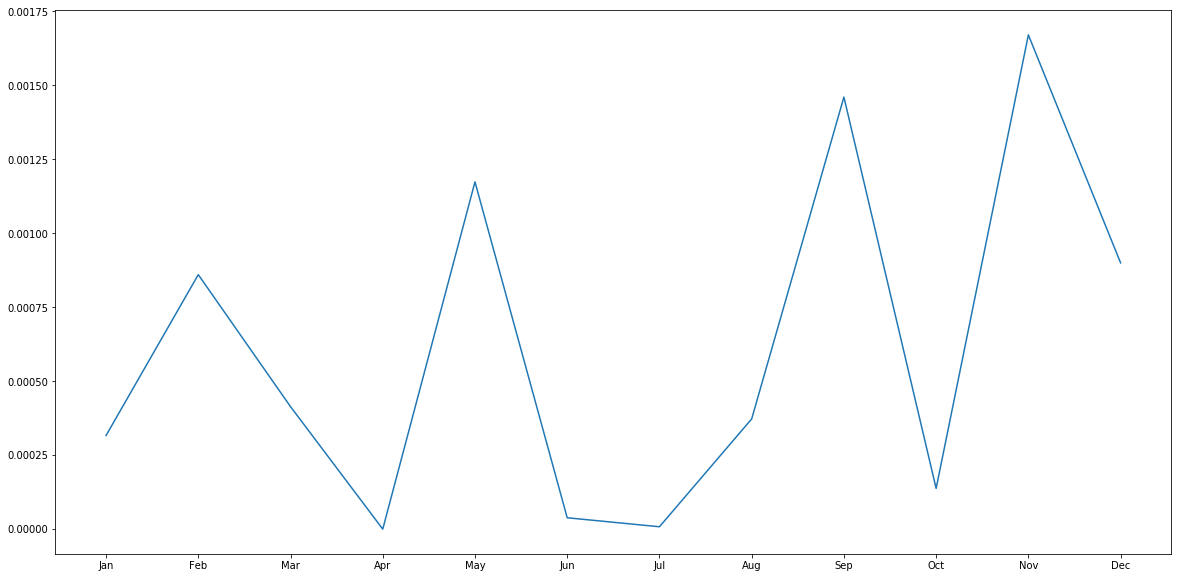

In [55]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(months,at_v_bb_diverg["jesus"])

In [26]:
at_diverg["black"]

[0.00037884309339564215,
 3.725358881423446e-05,
 1.771249809834341e-05,
 5.918193441090125e-06,
 0.07951090330282728,
 0.060178721095184406,
 0.0012206792917413,
 0.0091795488107701,
 0.0006312331720013109,
 0.0012829566972446527,
 0.0016148850553675542]

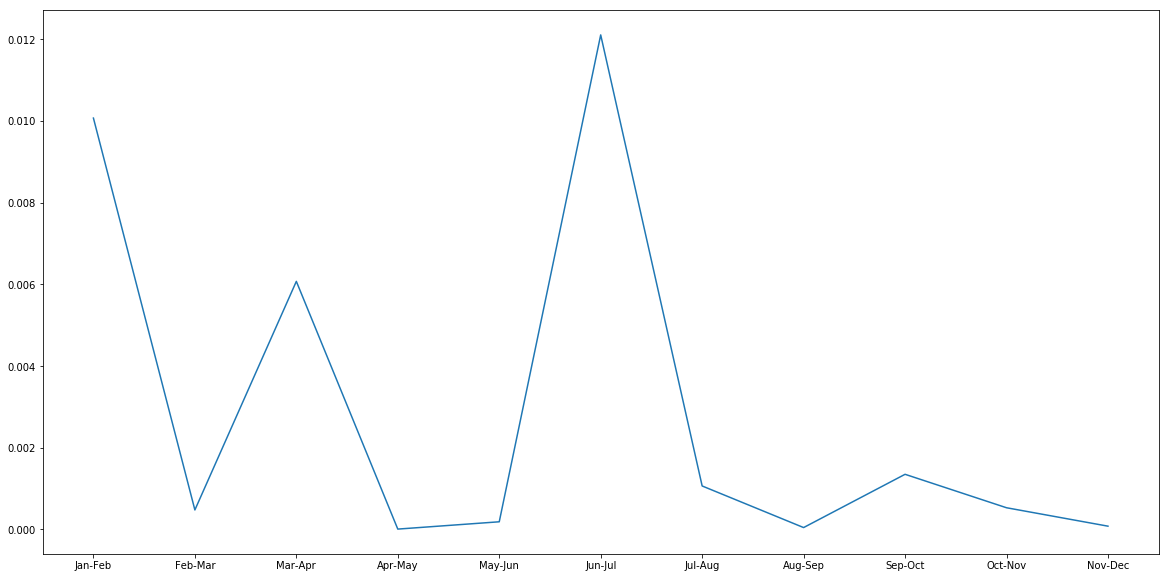

In [36]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot([months[i]+"-"+months[i+1] for i in range(11)], at_diverg["arab"])

In [5]:
adj_p["thehill"]["black"]

[0.743764817449028,
 0.7512971290211,
 0.7266709719082983,
 0.7555229547808078,
 0.7340221267257931,
 0.7356758467869579,
 0.665323152905112,
 0.6204552989280584,
 0.5436628259551243,
 0.70944001770695,
 0.6120689655172413,
 0.7157848710100568]

In [23]:
noun_p["breitbart"]["black"]

[0.2714805318704907,
 0.28645111197382284,
 0.3301617507136061,
 0.29943352215928026,
 0.29062155204119167,
 0.26027610950783875,
 0.29518467689002925,
 0.2875243664717349,
 0.2790991612087786,
 0.27478567826525463,
 0.27351265703399097,
 0.2529466295854853]

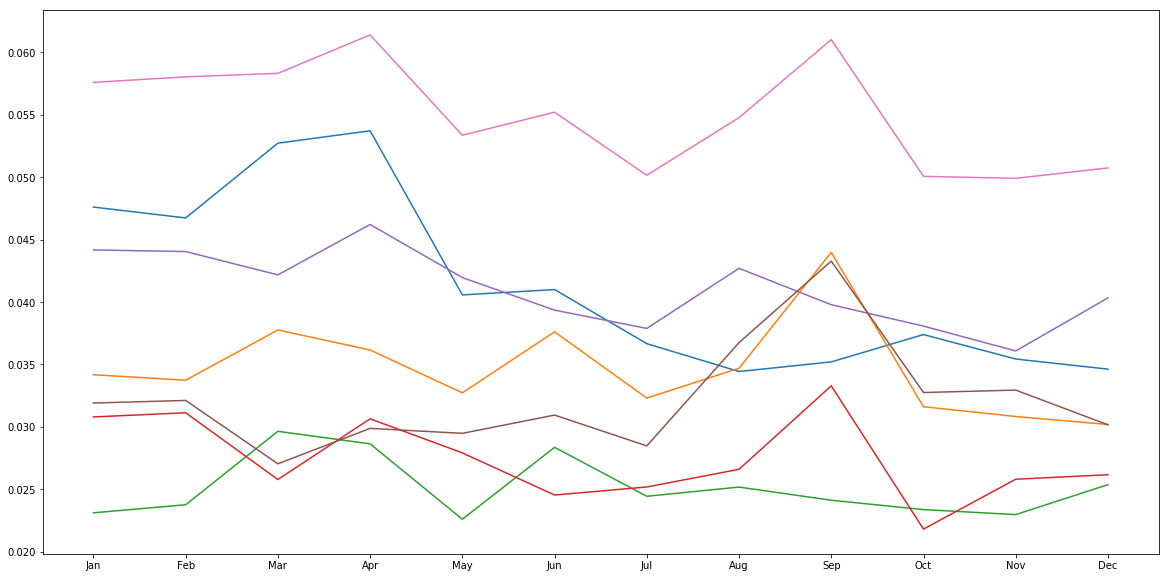

In [110]:
fig,ax=plt.subplots(figsize=(20,10))
for i in d:
    ax.plot(months,i)